<center><h1> Service: Photo-Interpretation Using ADC for CAP monitoring</h1></center>

<img src='https://crops.extension.iastate.edu/files/resize/styles/icm_news_large/public/icm/Intro-846x261.jpg?itok=iPntTOVu'/>

## Description
<p>CAP monitoring takes advantage of alerts such as false declarations and grassland mowing event generated by AI-based modules. These alerts must be analyzed so to be confirmed or rejected. This following service utilizes Sentinel ARD and provide decision-makers all the required tools to minimize the effort for Photo-Interpretation and optimize the validation process.</p>

## Data

Satellite imagery from the EU Copernicus Sentinel-1 and Sentinel-2 missions are used, resampled in 10m resolution. Sentinel-1&2 produducts have been widely used in agriculture monitoring. 

## Import libraries

In [1]:
import datacube
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Proj, transform
from datacube.utils import geometry
from datacube.utils.geometry import CRS,Geometry
import fiona
import rasterio.features
import geopandas as gpd
from fiona.crs import from_epsg
import xarray as xr
from shapely.geometry import shape
from dea_tools.plotting import rgb
import warnings
import os,sys
warnings.filterwarnings("ignore")

## ADC Configuration
Activation of the ADC database allowing data searching and loading

In [2]:
home_directory = '/home/eouser'
os.chdir(home_directory)

dc = datacube.Datacube(app="test",config=os.path.join(home_directory,"datacube.conf"))

## Parameters
The following parameters are set by user so to extract specific data from the cube and the LPIS. Users can define time extent, bands to examine and parcel id. It's worth mentioning that users can get parcels' auxilliary data either from the shapefile or from the database along with alerts and statistics related to them. 

In [3]:
# ADC product to use - In this scenario we utilize the Sentinel-2 processed Cloud Optimized GeoTIFFs above Lithuania
product= 's2_preprocessed_cyprus'

# add any buffer to the current geometry for better zoom out plot
buffer = 50

all_optical_bands = ['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12','SCL']

# open shapefile or connect to DB to retrieve ids and geometries
shape_file = 'shapefiles/burnt_parcels_cy_validated.shp'

# time extent 
d_start,d_end = '2020-03-01','2020-09-01'

## Helpful Functions

In [4]:
def geometry_mask(geoms, geobox, touches=False, invertion=False):
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=touches,
                                           invert=invertion)

def calculate_index(data, index):

    """
    Optical Indices Computation

    :param xarray: datacube_object
    :param string: you want to compute
    
    """
     
    if index.lower() == 'ndvi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return (B08 - B04) / (B08 + B04)
    if index.lower() == 'ndwi':
        B03 = data.B08.astype('float16')
        B08 = data.B04.astype('float16')
        return (B03 - B08) / (B08 + B03)
    if index.lower() == 'psri':
        B02 = data.B02.astype('float16')
        B06 = data.B06.astype('float16')
        B08 = data.B08.astype('float16')
        return (B04 - B02) / B06
    if index.lower() == 'nbr':
        B08 = data.B08.astype('float16')
        B12 = data.B12.astype('float16')
        return (B08 - B12) / (B08 + B12)
    if index.lower() == 'savi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        L = 0.428;
        return ((B08 - B04) / (B08 + B04 + L)) * (1.0 + L)
    else:
        return None
    
def cloud_data(data, index,fill_val=np.nan):
    
    """
    Cloud Masking Computation
    
    :param xarray: datacube_object
    :param index: you want to compute the cloud mask
    :param float: masking value (default:np.nan)
    
    """
    return xr.where((data.SCL>=4) & (data.SCL<=6), data[index.lower()], fill_val)

def getData(product,geom,geom_buffer,startDate,endDate,bands=all_optical_bands):
    
    """
    return an xarray of the data you want

    :param string: product_name
    :param geom: rasterized geometry
    :param geom: buffered_rasterized geometry
    :param string: initial_date
    :param string: final_date
    :param list[bands]: list of bands to be returned from DC
    """

    
    query = {
        'geopolygon': geom_buffer,
        'time': (startDate,endDate),
        'product': product
        }
    
    data = dc.load(output_crs="EPSG:3857",measurements=bands,resolution=(-10,10),**query,dask_chunks={})
    if len(data) == 0:
        return -1
    
    #ndvi calculation and masking of clouds only this index
    data['ndvi'] = calculate_index(data,'ndvi')
    data['nbr'] = calculate_index(data,'nbr')
    
    data['ndvi'] = cloud_data(data,'ndvi')
    mask = geometry_mask([geom], data.geobox, invertion=True)
    
    #masked data of ndvi based on input geometry
    masked_data = data.where(mask)
    
    #keep only "clearsky" time instances (real values of higher than a threshold)
    to_keep = masked_data['ndvi'].dropna(dim='time',thresh=0.2).time
    
    data = data.sel(time=to_keep)
    masked_data = masked_data.sel(time=to_keep)
    tt =  np.array([np.datetime64(datetime.strptime(str(k),'%Y-%m-%dT%H:%M:%S.%f000').strftime('%Y-%m-%d'))for k in data.time.values])
    data = data.assign_coords(time=('time',tt))
    masked_data = masked_data.assign_coords(time=('time',tt))
    #drop duplicates
    tt = np.unique(tt,return_index=True)[1]
    data = data.isel(time=tt)
    masked_data = masked_data.isel(time=tt)

    data = data.load()
    masked_data = masked_data.load()
    return data,masked_data

## Read Shapefile (or DB)

In [5]:
# open file and get geometry
ds = fiona.open(shape_file)
crs = geometry.CRS(ds.crs_wkt)

# add data to geopandas dataframe
gdf = gpd.GeoDataFrame.from_file(filename=shape_file,driver='ESRI Shapefile')

In [6]:
print(gdf.shape)
gdf.head()

(795, 5)


,PARCEL_ID,CROP_CODE,N_AREA,BURN_DATE,geometry
0,94260,226,4.7,2020-05-28 00:00:00,"POLYGON ((3684573.060 4175044.638, 3684674.389..."
1,192789,150,1.6,2020-07-22 00:00:00,"POLYGON ((3731951.145 4167215.013, 3731952.675..."
2,188896,8,5.5,2020-06-07 00:00:00,"POLYGON ((3730602.728 4167431.131, 3730605.847..."
3,29453,226,2.2,2020-08-01 00:00:00,"POLYGON ((3728319.248 4168179.205, 3728350.924..."
4,29450,226,4.3,2020-07-17 00:00:00,"POLYGON ((3728061.917 4168181.705, 3728061.950..."


In [7]:
# just for testing purposes
case = 230
print(gdf.iloc[case].PARCEL_ID)
print(gdf.iloc[case].BURN_DATE)


f = ds[case]
gdf_f = gdf.iloc[case:case+1].copy()

# get attributes
unique_id = f['properties']['PARCEL_ID']
area = f['properties']['N_AREA']
feature_geom = f['geometry']
geom = Geometry(feature_geom,crs)


geom_buffer = geom.buffer(100)  
bounds = shape(feature_geom).bounds
s2,s2_mask = getData(product,geom,geom_buffer,d_start,d_end)
dates_str = np.array([str(d).split('T')[0] for d in s2_mask.time.values])

65141
2020-05-23 00:00:00


## RGB True Color

RGB represents the natural color of an area of interest. It is generated by stacking Red (Band 4), Blue (Band 3) and Green (Band 2) bands. In common shorthand, it gives an image of what the real world looks like.

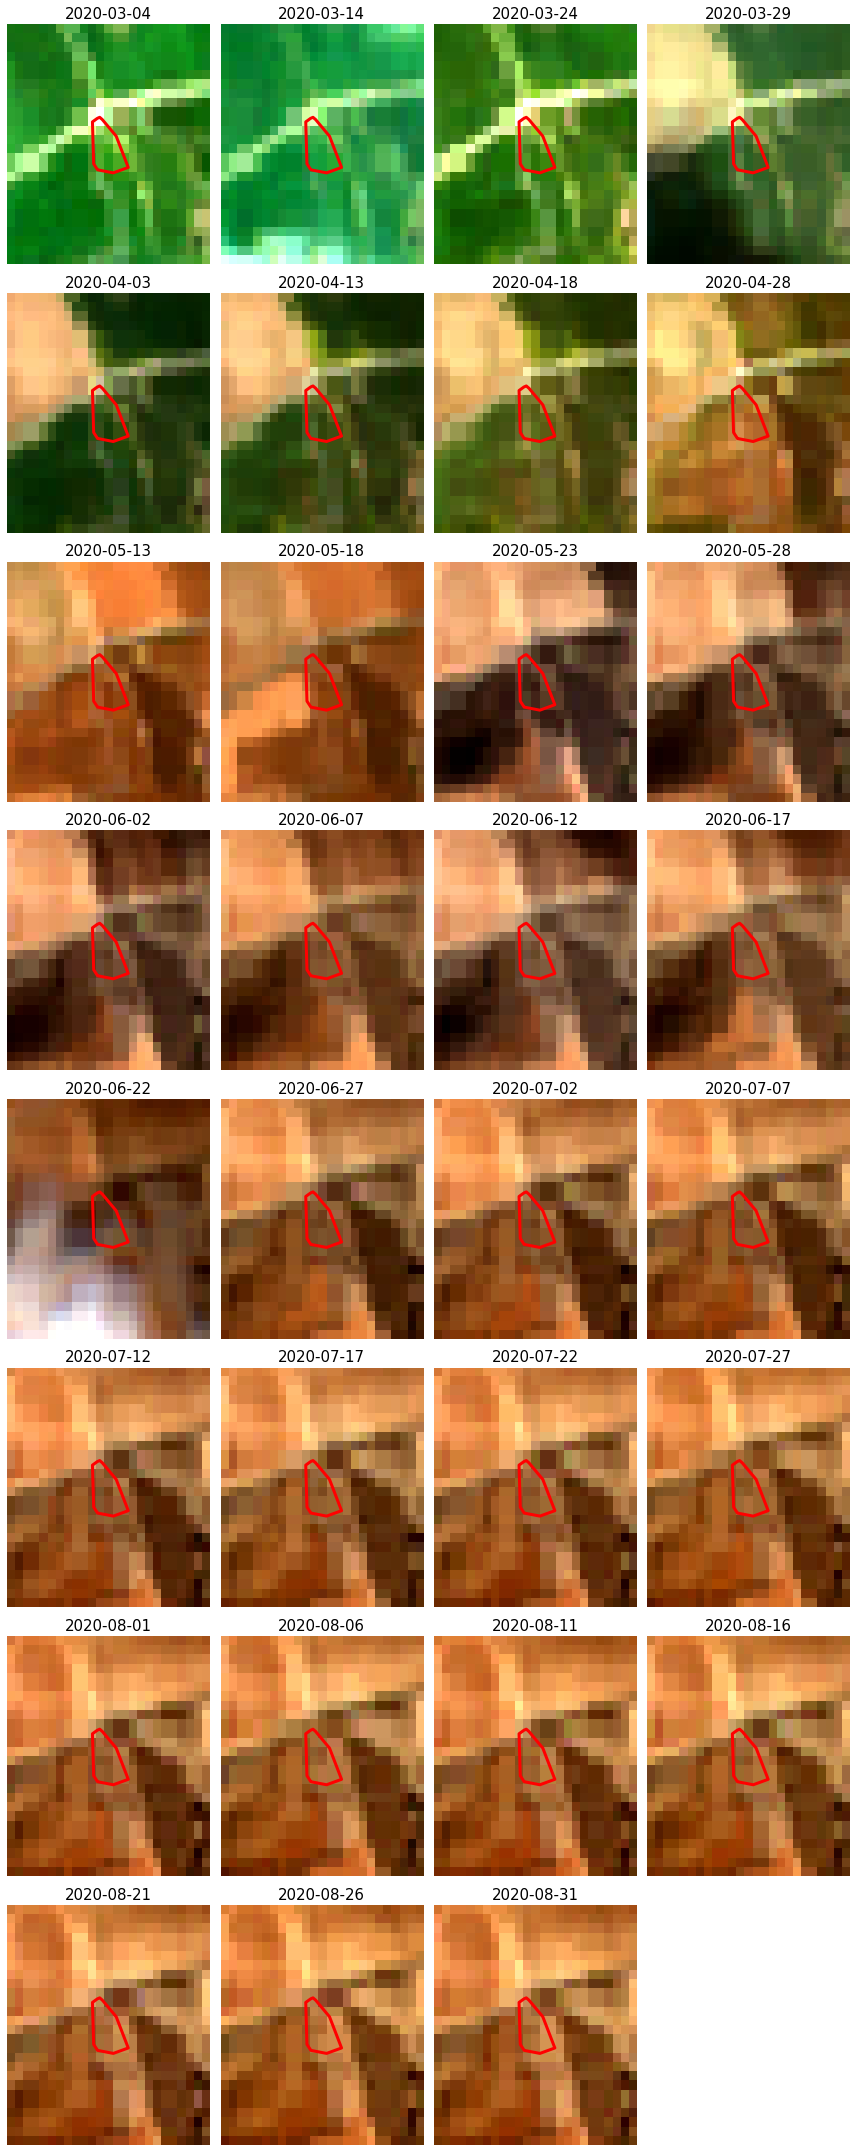

In [8]:
pseudo_col = ["B04", "B03", "B02"]
col_n = 4

# check if an additional row is needed for the plot
if len(dates_str)%col_n==0:
    row_n = len(dates_str)//col_n
else:
    row_n = len(dates_str)//col_n + 1

    
fig, ax = plt.subplots(row_n,col_n, figsize=(12,30))

n = 0 

stop = False

for i in range(row_n):
    for j in range(col_n):
        
        gdf_f.geometry.to_crs("EPSG:3857").plot(ax=ax[i][j],facecolor='none',edgecolor='red',linewidth=3)
        s2[pseudo_col].isel(time=n).to_array().plot.imshow(ax=ax[i][j], robust=True, add_labels=False)
        
        ax[i][j].set_title(dates_str[n],fontsize=15)
        ax[i][j].axis('off')
        
        n += 1
        if n==len(dates_str):
            stop = True
            break
    if stop:
        break

fig.delaxes(ax[-1][-1])

plt.tight_layout()
plt.axis('off')
plt.show()

## NBR Case

In [9]:
dates = np.array([datetime.strptime(d,'%Y-%m-%d') for d in dates_str])
nbr_case = np.array(s2_mask['nbr'].data).reshape(len(dates),-1)
nbr_case = pd.DataFrame(data=nbr_case.T,columns=dates)

## NBR plot (median over parcel geometry)

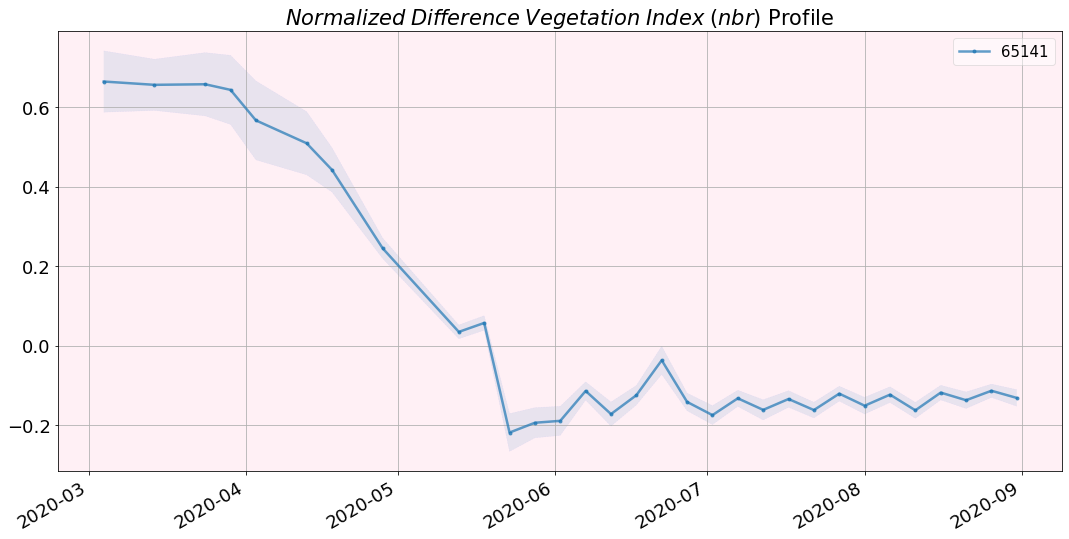

In [10]:
fig,ax = plt.subplots(figsize=(18,9))
 
nbr_case.median().plot(lw=2.5,alpha=0.7,ax=ax,marker='.',label=unique_id)
lower_bound = nbr_case.median()-nbr_case.std()
upper_bound = nbr_case.median()+nbr_case.std()
lower_bound.plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,legend=False,ax=ax)
upper_bound.plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,ax=ax)
ax.fill_between(x=lower_bound.index, y1=lower_bound, y2 = upper_bound, alpha=0.1, cmap=plt.cm.get_cmap("winter"))
ax.set_facecolor('lavenderblush')    
plt.title('$\it{Normalized\;Difference\;Vegetation\;Index}\;(nbr)$ Profile',fontsize=21)
ax.tick_params(labelsize=18)
plt.grid()
plt.legend(fontsize=15,fancybox=True, framealpha=0.5)
# plt.savefig("nbr_family.png", facecolor='white',dpi=600,bbox_inches='tight')
plt.show()